In [67]:
import numpy as np
import torch
import torch.nn as nn
import random

import transformers

from model import TrajectoryModel
from trajectory_gpt2 import GPT2Model

from matplotlib import pyplot as plt

import gymnasium as gym
import argparse
import time

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [69]:
# from time import time

# start = time()
# for i in range(1_000_000):
#     print(i)
# print(f'run time for printing: {time() - start}')

# start = time()
# for _ in range(1_000_000):
#     pass
# print(f'run time for no printing: {time() - start}')

## Loading the trajectories from data

In [70]:
traj_states = torch.load("data/acrobot_states.pt")
traj_actions = torch.load("data/acrobot_actions.pt")
traj_states.to(device)
traj_states.to(device)
print("traj_states size", traj_states.size())
print("traj_actions size", traj_actions.size())
state_dim  = traj_states.size()[2]
print("state_dim", state_dim)
#print("act_dim", act_dim)
act_dim  = 1
n_traj = traj_states.size()[0]
traj_len = traj_states.size()[1]
print("n_traj = ", n_traj)
print("traj_len = ", traj_len)

traj_states size torch.Size([500000, 100, 6])
traj_actions size torch.Size([500000, 100])
state_dim 6
n_traj =  500000
traj_len =  100


## Normalizing the data

In [71]:
# print(torch.mean(traj_states, dim = 0).repeat(n_traj, 1, 1).size())
# print(torch.mean(traj_actions, dim = 0).repeat(n_traj, 1, 1).size())
#traj_states = (traj_states - torch.mean(traj_states, dim = 1).repeat(n_traj, 1, 1)) / torch.std(traj_states, dim = 1).repeat(n_traj,1,1)
traj_states = (traj_states - torch.mean(traj_states, dim=(0,1), keepdim=True)) / torch.std(traj_states, dim=(0,1), keepdim=True)
#traj_actions = (traj_actions - torch.mean(traj_act, dim=0).repeat(n_traj, 1)) / torch.std(traj_actions, dim=0)#.repeat(n_traj, 1)
# #yyyy = traj_actions - torch.mean(traj_actions, dim = 0).repeat(n_traj, 1, 1)

In [72]:
# print(traj_states.shape)
# mean = torch.mean(traj_states, dim=0, keepdim=True)  # shape: [n_traj, 1, dim]
# std = torch.std(traj_states, dim=0, keepdim=True)    # shape: [n_traj, 1, dim]
# traj_states = (traj_states - mean) / std

# print(traj_actions.shape)
# mean = torch.mean(traj_actions, dim=0, keepdim=True)  # shape: [n_traj, 1]
# std = torch.std(traj_actions, dim=0, keepdim=True)    # shape: [n_traj, 1]
# traj_actions = (traj_actions - mean) / std

## Splitting the data into Training and Testing set

In [73]:
train_traj_states = traj_states[0:int(0.95*n_traj),:,:]
train_traj_actions = traj_actions[0:int(0.95*n_traj),:]

n_train_traj = train_traj_states.size()[0]

test_traj_states = traj_states[int(0.95*n_traj):,:,:]
test_traj_actions = traj_actions[int(0.95*n_traj):,:]

n_test_traj = test_traj_states.size()[0]

## Function to obtain batch of trajectories

In [74]:
def get_batch(batch_size, n_traj, traj_states, traj_actions):
    idxs = random.choices(range(n_traj), k=batch_size)
    batch_states = traj_states[idxs,:,:]
    batch_actions = traj_actions[idxs,:]
    
    return batch_states, batch_actions.unsqueeze(-1)

## Decision Transformer Code

In [75]:
class TransDynaMo(TrajectoryModel):

    """
    This model uses GPT to model (state_1, action_1, state_2, action_2, ...)
    """

    def __init__(
            self,
            state_dim,
            act_dim,
            hidden_size,
            max_length=None,
            max_ep_len=100,
            action_tanh=True,
            **kwargs
    ):
        super().__init__(state_dim, act_dim, max_length=max_length)

        self.hidden_size = hidden_size
        config = transformers.GPT2Config(
            vocab_size=1,  # doesn't matter -- we don't use the vocab
            n_embd=hidden_size,
            **kwargs
        )

        # note: the only difference between this GPT2Model and the default Huggingface version
        # is that the positional embeddings are removed (since we'll add those ourselves)
        self.transformer = GPT2Model(config)

        self.embed_timestep = nn.Embedding(max_ep_len, hidden_size)
        self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
        self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)

        self.embed_ln = nn.LayerNorm(hidden_size)

        self.predict_state = torch.nn.Linear(hidden_size, self.state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(hidden_size, self.act_dim)] + ([nn.Tanh()] if action_tanh else []))
        )
        self.predict_return = torch.nn.Linear(hidden_size, 1)

    def forward(self, states, actions, timesteps, attention_mask=None):
        
        states = states.to(device)
        actions = actions.to(device)

        batch_size, seq_length = states.shape[0], states.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not

            # Create an attention mask tensor of shape (batch_size, seq_length, seq_length) with ones on the diagonal and below
            attention_mask = torch.ones((batch_size, seq_length), device = device, dtype=torch.long)
        
        ones_matrix = torch.triu(torch.ones(seq_length, seq_length)*float('-inf'), diagonal=1)
        encoder_attention_mask = ones_matrix.unsqueeze(0).repeat(batch_size, 1, 1)
        zeros_matrix = torch.zeros(batch_size, seq_length, seq_length)

        # embed each modality with a different head
        state_embeddings = self.embed_state(states)
        action_embeddings = self.embed_action(actions)
        time_embeddings = self.embed_timestep(timesteps)

        # time embeddings are treated similar to positional embeddings
        state_embeddings = state_embeddings + time_embeddings
        action_embeddings = action_embeddings + time_embeddings
        

        # which works nice in an autoregressive sense since states predict actions
        stacked_inputs = torch.stack(
            (state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(batch_size, 2*seq_length, self.hidden_size)
        stacked_inputs = self.embed_ln(stacked_inputs)

        # to make the attention mask fit the stacked inputs, have to stack it as well
        stacked_attention_mask = torch.stack(
            (attention_mask, attention_mask), dim=1
        ).permute(0, 2, 1).reshape(batch_size, 2*seq_length)
        
        combined_mask_top = torch.cat([encoder_attention_mask, zeros_matrix], dim=2)
        combined_mask_bottom = torch.cat([zeros_matrix, encoder_attention_mask], dim=2)
        stacked_encoder_attention_mask = torch.cat([combined_mask_top, combined_mask_bottom], dim=1).to(device)
        

        # we feed in the input embeddings (not word indices as in NLP) to the model
        transformer_outputs = self.transformer(
            inputs_embeds=stacked_inputs,
            attention_mask=stacked_attention_mask,
            encoder_attention_mask = stacked_encoder_attention_mask
        )
        x = transformer_outputs['last_hidden_state']

        # reshape x so that the second dimension corresponds to the original
        # returns (0), states (1), or actions (2); i.e. x[:,1,t] is the token for s_t
        x = x.reshape(batch_size, seq_length, 2, self.hidden_size).permute(0, 2, 1, 3)

        # get predictions
        state_preds = self.predict_state(x[:,1])    # predict next state given state and action
        action_preds = self.predict_action(x[:,0])  # predict next action given state

        return state_preds, action_preds

    def get_state(self, states, actions, timesteps, **kwargs):

        states = states.reshape(1, -1, self.state_dim)
        actions = actions.reshape(1, -1, self.act_dim)
        timesteps = timesteps.reshape(1, -1)

        if self.max_length is not None:
            states = states[:,-self.max_length:]
            actions = actions[:,-self.max_length:]
            timesteps = timesteps[:,-self.max_length:]

            # pad all tokens to sequence length
            attention_mask = torch.cat([torch.zeros(self.max_length-states.shape[1]), torch.ones(states.shape[1])])
            attention_mask = attention_mask.to(dtype=torch.long, device=states.device).reshape(1, -1)
            states = torch.cat(
                [torch.zeros((states.shape[0], self.max_length-states.shape[1], self.state_dim), device=states.device), states],
                dim=1).to(dtype=torch.float32)
            actions = torch.cat(
                [torch.zeros((actions.shape[0], self.max_length - actions.shape[1], self.act_dim),
                             device=actions.device), actions],
                dim=1).to(dtype=torch.float32)
            timesteps = torch.cat(
                [torch.zeros((timesteps.shape[0], self.max_length-timesteps.shape[1]), device=timesteps.device), timesteps],
                dim=1
            ).to(dtype=torch.long)
        else:
            attention_mask = None

        state_preds, action_preds = self.forward(
            states, actions, timesteps, attention_mask=attention_mask, **kwargs)
        
#         print(state_preds.size())
#         print(state_preds[0,-1].size())

        return state_preds[0,-1]

In [76]:
model = TransDynaMo(
            state_dim=state_dim,
            act_dim=act_dim,
            max_length=20,
            max_ep_len=100,
            hidden_size=128,
            n_layer=3,
            n_head=4,
            n_inner=4*128,
            activation_function='relu',
            n_positions=1024,
            resid_pdrop=0.1,
            attn_pdrop=0.1,
            n_ctx=600
        )

## Training

In [77]:
model.to(device)
batch_size = 256
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.1,
    weight_decay=1e-4,
)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda steps: min((steps+1)/10000, 1)
)

n_epochs = 600

loss_horizon = 6

train_losses = torch.zeros(n_epochs)

for n in range(n_epochs):
    print('epoch: ', n)
    state_batch, action_batch = get_batch(batch_size, n_train_traj, train_traj_states, train_traj_actions)

    state_pred, action_preds = model.forward(state_batch, action_batch, (torch.arange(0,traj_len,1).unsqueeze(0)).to(device))

    loss = nn.MSELoss()
    #l = loss(state_pred,state_batch.to(device))
    l = loss(state_pred[:,0:loss_horizon,:],state_batch[:,0:loss_horizon,:].to(device))
    train_losses[n] = l.detach().cpu().item()
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

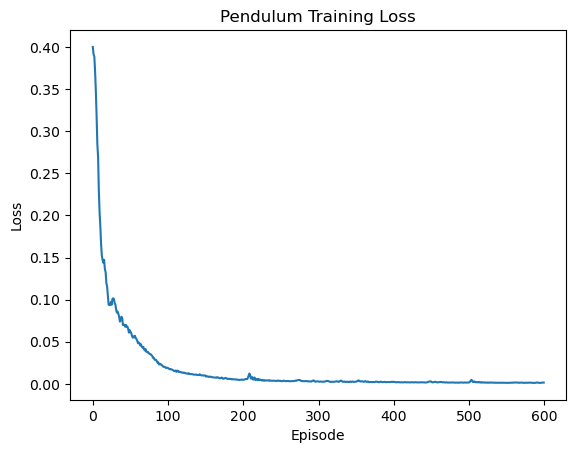

In [78]:
plt.plot(train_losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Pendulum Training Loss")
plt.savefig("figures/pendulum_training_loss_mse.pdf")

## Evaluation

In [79]:
model.eval()

n_eval = 100
eval_losses = torch.zeros(n_eval)

#states_eval_batch, actions_eval_batch = get_batch(n_eval, n_test_traj, test_traj_states, test_traj_actions)

for n in range(n_eval):

    states_eval_batch, actions_eval_batch = get_batch(1, n_test_traj, test_traj_states, test_traj_actions)
    state = states_eval_batch[0,0,:]
    action = actions_eval_batch[0,0,:]

    # we keep all the histories on the device
    # note that the latest action will be "padding"
    states = state.reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = action.reshape(1, act_dim).to(device=device, dtype=torch.float32)
    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(99):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)

        pred_state = model.get_state(
            states.to(dtype=torch.float32) ,
            actions.to(dtype=torch.float32),
            (torch.arange(0,t+1,1).unsqueeze(0)).to(device)
        )

        actions[-1] = actions_eval_batch[0,t+1,:].reshape(1, act_dim)

        cur_state = (pred_state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        
    loss = nn.MSELoss()
    l = loss(states.unsqueeze(0),states_eval_batch.to(device))
    eval_losses[n] = l.detach().cpu().item()

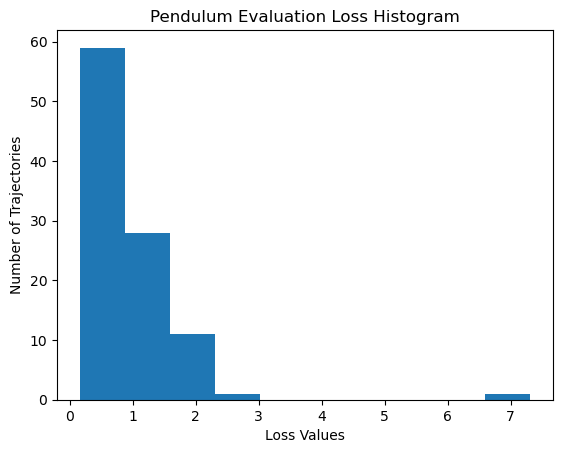

In [80]:
plt.hist(eval_losses)
plt.xlabel("Loss Values")
plt.ylabel("Number of Trajectories")
plt.title("Pendulum Evaluation Loss Histogram")
plt.savefig("figures/pendulum_evaluation_loss_hist_mse.pdf")

In [81]:
model.eval()

n_min = torch.argmin(eval_losses).item()

n_eval = 1
eval_losses_2 = torch.zeros(99)

#states_i, actions_i = states_eval_batch[n_min,:,:].unsqueeze(0), actions_eval_batch[n_min,:,:].unsqueeze(0)

for n in range(n_eval):

    states_i, actions_i = get_batch(1, n_test_traj, test_traj_states, test_traj_actions)

    state = states_i[0,0,:]
    action = actions_i[0,0,:]

    # we keep all the histories on the device
    # note that the latest action will be "padding"
    states = state.reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = action.reshape(1, act_dim).to(device=device, dtype=torch.float32)
    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(99):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)

        pred_state = model.get_state(
            states.to(dtype=torch.float32) ,
            actions.to(dtype=torch.float32),
            (torch.arange(0,t+1,1).unsqueeze(0)).to(device)
        )

        actions[-1] = actions_i[0,t+1].reshape(1, act_dim)

        cur_state = (pred_state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        
#         print(states.size())
#         print(states_i[0,0:t+2,:].size())
        
        loss = nn.MSELoss()
        l = loss(states,(states_i[0,0:t+2,:]).to(device))
        eval_losses_2[t] = l.detach().cpu().item()

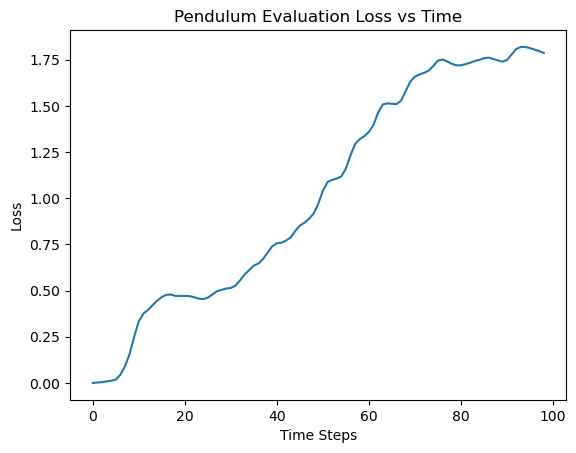

In [82]:
plt.plot(eval_losses_2)
plt.xlabel("Time Steps")
plt.ylabel("Loss")
plt.title("Pendulum Evaluation Loss vs Time")
plt.savefig("figures/pendulum_evaluation_loss_time_mse_2.pdf")

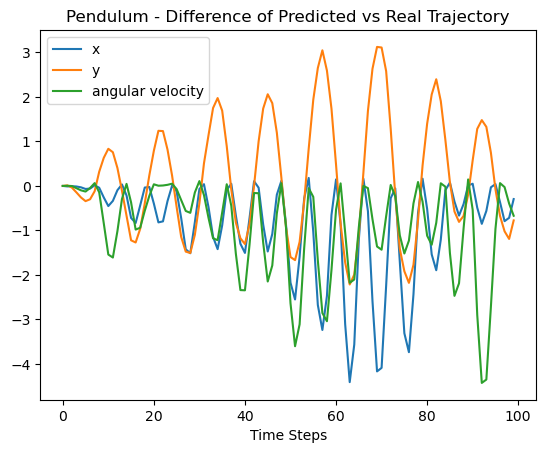

In [83]:
diff = states_i - states.to('cpu')
diff = diff.detach().numpy()
plt.plot(diff[0,:,0], label = "x")
plt.plot(diff[0,:,1], label = "y")
plt.plot(diff[0,:,2], label = "angular velocity")
plt.legend()
plt.xlabel("Time Steps")
#plt.ylim([-6,6])
#plt.ylabel("Loss")
plt.title("Pendulum - Difference of Predicted vs Real Trajectory")
plt.savefig("figures/pendulum_test_diff_mse_2.pdf")

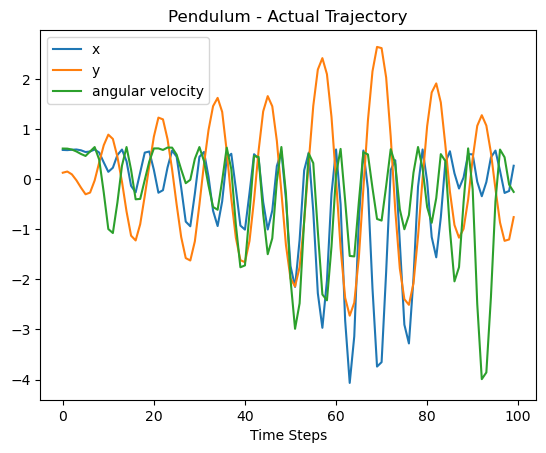

In [84]:
plt.plot(states_i[0,:,0], label = "x")
plt.plot(states_i[0,:,1], label = "y")
plt.plot(states_i[0,:,2], label = "angular velocity")
plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")

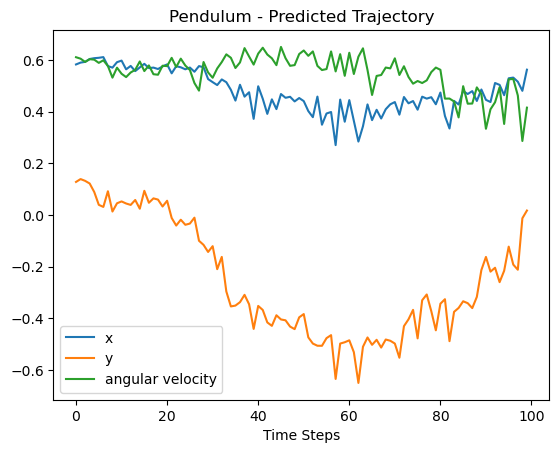

In [85]:
states = states.detach().cpu()
plt.plot(states[0:,0], label = "x")
plt.plot(states[:,1], label = "y")
plt.plot(states[:,2], label = "angular velocity")
plt.legend()
plt.xlabel("Time Steps")
#plt.ylabel("Loss")
#plt.ylim([-6,6])
plt.title("Pendulum - Predicted Trajectory")
plt.savefig("figures/pendulum_pred_real_mse_2.pdf")


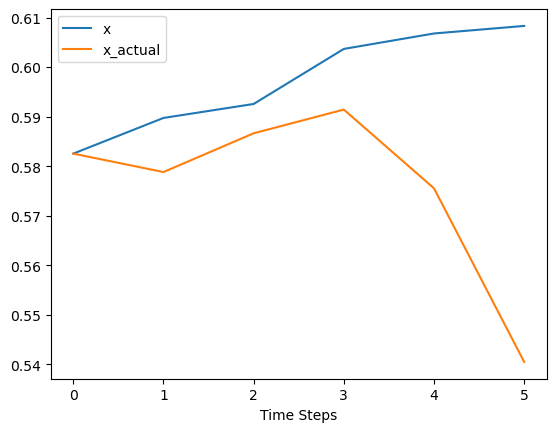

In [86]:
#plt.plot(states_i[0,0:loss_horizon,0], label = "x_actual")
#plt.plot(states[0,0:loss_horizon,0], label = "x")

plt.plot(states[0:loss_horizon,0], label = "x")

plt.plot(states_i[0,0:loss_horizon,0], label = "x_actual")
plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

#plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")

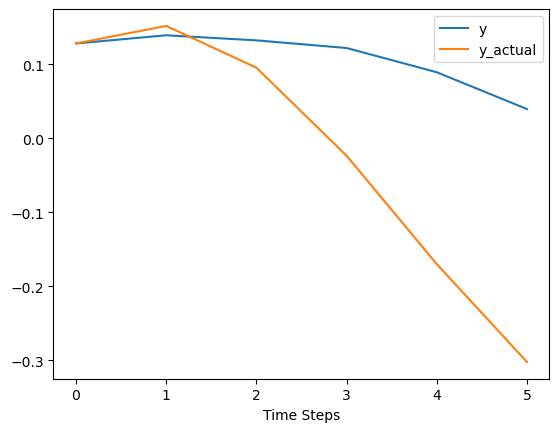

In [87]:
plt.plot(states[0:loss_horizon,1], label = "y")

plt.plot(states_i[0,0:loss_horizon,1], label = "y_actual")
plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

#plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")

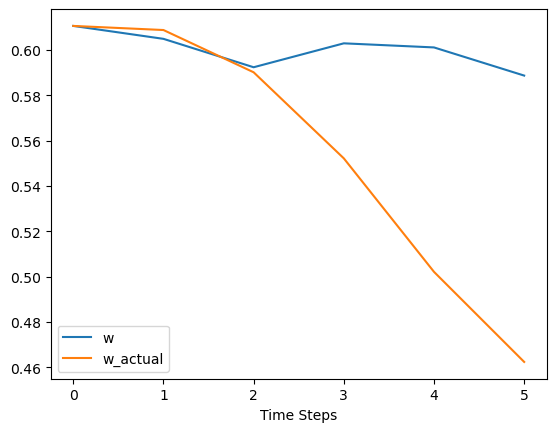

In [88]:
plt.plot(states[0:loss_horizon,2], label = "w")

plt.plot(states_i[0,0:loss_horizon,2], label = "w_actual")

plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

#plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")